In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time 
from matplotlib import pyplot as plt

# ANN from scratch 

## Activation Functions

In [ ]:
def linear(x):
  return x

def linear_derivative(x):
  return np.ones(x.shape)

def sig(x):
    return 1/(1 + np.exp(-x))

def sig_derivative(x):
    s = sig(x)
    ds = s*(1-s)
    return ds

def relu(x):
    return np.where(x > 0, x, 0.0)
    
def relu_derivative(x):
   return np.where(x > 0, 1,  0.0) 

def leaky_relu(x):
    return np.where(x > 0, x, x * 0.1)    

def leaky_relu_derivative(x):
   return np.where(x > 0, 1,  0.1) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1-(tanh(x)**2)

## Forward Phase

In [ ]:

def calculate_layer_output(W_nextL, al ,b_nextL, activation_func):  
    '''
    inputs:
        w_nextL : is weights matrix in shape(k * n), k: number of cell in next layer, n: number of cell in current layer
        al : input vector of current layer in shape(n * 1)
        b_nextL : bias vector in shape (n * 1)
    output :
        a_nextL : output of this layer in shape (n * 1)
    '''  
    return activation_func((W_nextL @ al) + b_nextL)


def claculate_network_output(weights_matrix_list, input_data, bias_list, activation_func):
    '''
    inputs : 
        weights_matrix_list : a list contains weights matrix in order of layers, here it contains 3 weights matrix
        input data : vector of an image
        bias_list : a list contains bias vector for each layer in order
    output:
        network_output : final result of network which is digit 
    '''
    last_layer_num = len(weights_matrix_list)-1
    a_list = []
    a_list.append(input_data)
    for i in range(len(weights_matrix_list)):
        if i == last_layer_num: # we chose sig for last layer, but feel free to change
            activation_func = sig
        res = calculate_layer_output(weights_matrix_list[i],a_list[i],bias_list[i], activation_func)
        a_list.append(res)
    return a_list


## Loss Functions

In [ ]:
def MSE(actual_value, Ndata,weights_matrix_list,bias_list, activation_func):
    loss = 0
    for i in range(Ndata):
        predicted_output = claculate_network_output(weights_matrix_list,actual_value[i][0],bias_list, activation_func)
        loss += ((predicted_output[-1] - actual_value[i][1])**2)
    return loss/Ndata

## Backward Phase

In [ ]:
def calculate_deriviate_elementwise(weights_matrix,bias,a_prevL,dcost_dat, layer_num, activation_derivative ):
    if layer_num == (layer_num-1): #for last layer we always use sigmoid 
        activation_derivative = sig_derivative
    row,col = weights_matrix.shape
    weights_matrix_deriviate = np.zeros((row,col)) 
    bias_deriviate = np.zeros((row,1))
    dcost_dap = np.zeros((col,1)) 
    for j in range(row):
        bias_deriviate[j] = dcost_dat[j] * activation_derivative(np.dot(weights_matrix[j][:],a_prevL)+ bias[j])
        for k in range(col):
            weights_matrix_deriviate[j][k] = bias_deriviate[j]*a_prevL[k]
    if layer_num != 0:        
        for k in range(col):
            for j in range(row):
                dcost_dap[k] += bias_deriviate[j] * weights_matrix[j][k]
    return weights_matrix_deriviate,bias_deriviate, dcost_dap

def calculate_deriviate_vecorized(weights_matrix,bias,a_prevL,dcost_dat, layer_num, activation_derivative):
    if layer_num == (layer_num -1): #for last layer we always use sigmoid 
        activation_derivative = linear_derivative
    row,col = weights_matrix.shape
    dcost_dap = np.zeros((col,1),dtype=np.float64) 
    bias_deriviate = dcost_dat * activation_derivative(np.dot(weights_matrix,a_prevL)+ bias)
    weights_matrix_deriviate = bias_deriviate @ np.transpose(a_prevL)
    if layer_num != 0: #for first layer we dont need dcost/da
        dcost_dap = np.transpose(weights_matrix) @ bias_deriviate
    return weights_matrix_deriviate,bias_deriviate, dcost_dap
       
def calculate_gradian(weights_matrix_list,a_list, bias_list, image_label, vectorized, activation_derivative):
    global layers_num
    weights_matrix_deriviate_list= []
    bias_deriviate_list = []
    dcost_da_list = [0 for x in range(layers_num)]
    dcost_daj = 2*(a_list[-1]-image_label)
    dcost_da_list[layers_num-1] = dcost_daj
    for i in range(layers_num-1,-1,-1):
        if vectorized == 1:
            w,b,d = calculate_deriviate_vecorized(weights_matrix_list[i],bias_list[i],a_list[i],dcost_da_list[i],i, activation_derivative)
        else :
            w,b,d = calculate_deriviate_elementwise(weights_matrix_list[i],bias_list[i],a_list[i],dcost_da_list[i],i, activation_derivative)
        weights_matrix_deriviate_list.append(w)
        bias_deriviate_list.append(b)
        dcost_da_list[i-1] = d

    return weights_matrix_deriviate_list[::-1],bias_deriviate_list[::-1]

def stochastic_gradiant_descent(weights_matrix_list, bias_list, batch, vectorized, activation_func, activation_derivative):
    global layers_num, layers_cellNums
    weights_Gmatrix_list =[]
    bias_G_list = []
    
    for i in range(layers_num):
        matrix = np.zeros((layers_cellNums[i+1],layers_cellNums[i] ), dtype=np.float64)
        weights_Gmatrix_list.append(matrix)
    
    for cell_num in layers_cellNums[1:]:
        bias_G_list.append(np.zeros((cell_num,1), dtype=np.float64))
   
    for x, y, _ in batch : 
        a_list = claculate_network_output(weights_matrix_list,x, bias_list, activation_func)
        weights_matrix_deriviate_list,bias_deriviate_list = calculate_gradian(weights_matrix_list,a_list,bias_list, y, vectorized, activation_derivative)
        for i in range(len(weights_Gmatrix_list)):
            weights_Gmatrix_list[i] += weights_matrix_deriviate_list[i]
            bias_G_list[i] += bias_deriviate_list[i]
    return weights_Gmatrix_list, bias_G_list

## Train Function

In [ ]:
def init_matrices(layers_cellNums):
    # initiate wieght and bias matrices
    weights_matrix_list = []
    bias_list = []
    for i in range(len(layers_cellNums)-1):
      np.random.seed(seed=5 + i)
      weights_matrix_list.append(np.random.normal(0, 1, size=(layers_cellNums[i+1],layers_cellNums[i])).astype(np.float64))
    for i in range(1, len(layers_cellNums)): 
      np.random.seed(seed=15 -i  )
      bias_list.append(np.zeros((layers_cellNums[i],1),dtype= np.float64))
    return weights_matrix_list, bias_list

In [ ]:
def train(epoch_num, batch_size, train_data, learning_rate, vectorized,activation_func, activation_derivative):
    weights_matrix_list1, bias_list1 = init_matrices(layers_cellNums)
    cost_list =[]
    for i in range(epoch_num):
        random.shuffle(train_data)
        batch_list = [train_data[x:x+batch_size] for x in range(0, len(train_data), batch_size)]
        for batch in batch_list:
            weights_Gmatrix_list1, bias_G_list1 = calculate_gradian(weights_matrix_list1,bias_list1, batch, vectorized, activation_func, activation_derivative)
            for i in range(len(weights_matrix_list1)):
                weights_matrix_list1[i] -= (learning_rate *weights_Gmatrix_list1[i])/batch_size
                bias_list1[i] -= (learning_rate * bias_G_list1[i])/ batch_size
        cost_list.append(MSE(train_data,len(train_data),weights_matrix_list1,bias_list1, activation_func))
    return weights_matrix_list1, bias_list1, cost_list
            
    

## Accuracy

In [ ]:
def calculate_accuracy(actual_data, Nactual_data,weights_matrix_list,bias_list, activation_func):
    correct_sample = 0
    for i in range(Nactual_data):
        predicted_output = claculate_network_output(weights_matrix_list,actual_data[i][0],bias_list, activation_func)
        if np.argmax(predicted_output[-1]) == np.argmax(actual_data[i][1]):
            correct_sample += 1
    return correct_sample/Nactual_data

## Plotters

In [ ]:
def loss_plotter(actual_data,num_entries, weights_matrix_list, bias_list, cost_list, activation_func ):
    accuracy = calculate_accuracy(actual_data, num_entries,weights_matrix_list,bias_list, activation_func )
    print("accuracy is: {0:.4f} ".format(accuracy*100))
    norm_list = [(np.linalg.norm(x)**2) for x in cost_list]
    plt.plot(norm_list)

## Handwriten Digit Recognition

## Model Architecture 

In [ ]:
layers_num = 3 # number of layers 
input_size = [28*28] 
hidden_layers_size = [16, 16]
output_size = [10]
layers_cellNums = input_size + hidden_layers_size + output_size

## Load Dataset

In [2]:

def load_train_set():
    # Reading The Train Set
    train_images_file = open('train-images.idx3-ubyte', 'rb')
    train_images_file.seek(4)
    num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
    train_images_file.seek(16)

    train_labels_file = open('train-labels.idx1-ubyte', 'rb')
    train_labels_file.seek(8)

    train_set = []
    for n in range(num_of_train_images):
        image = np.zeros((784, 1))
        for i in range(784):
            image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
        
        label_value = int.from_bytes(train_labels_file.read(1), 'big')
        label = np.zeros((10, 1))
        label[label_value, 0] = 1
        
        train_set.append((image, label))
    return train_set


In [3]:

def load_test_set():
    # Reading The Test Set
    test_images_file = open('t10k-images.idx3-ubyte', 'rb')
    test_images_file.seek(4)

    test_labels_file = open('t10k-labels.idx1-ubyte', 'rb')
    test_labels_file.seek(8)

    num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
    test_images_file.seek(16)

    test_set = []
    for n in range(num_of_test_images):
        image = np.zeros((784, 1))
        for i in range(784):
            image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
        
        label_value = int.from_bytes(test_labels_file.read(1), 'big')
        label = np.zeros((10, 1))
        label[label_value, 0] = 1
        
        test_set.append((image, label))
    
    return test_set


In [4]:
train_set = load_train_set()
test_set = load_test_set()

### Plot a Sample of data

In [5]:
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')

In [6]:
def check_sets(checking_set):
    x = np.random.randint(0,len(checking_set))
    show_image(checking_set[x][0])
    print(np.argmax(checking_set[x][1]))
    plt.show()


5


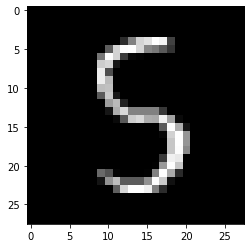

In [7]:
check_sets(train_set)

## Compare Runtime of Elementwise vs Vectorized Calculation

### Train Elementwise

In [220]:
%%time
weights_matrix_list_unvec, bias_list_unvec, cost_list_unvec = train(epoch_num = 20,
                                                                    batch_size = 10,
                                                                    train_data = train_set[:100],
                                                                    learning_rate = 0.01,
                                                                    vectorized = 0,
                                                                    activation_func = sig,
                                                                    activation_derivative = sig_derivative) 

CPU times: user 1min 25s, sys: 50.4 s, total: 2min 16s
Wall time: 34 s


accuracy is: 76.0000 


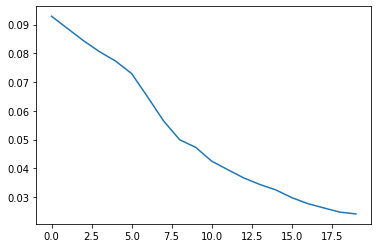

In [221]:
loss_plotter(train_set, 100, weights_matrix_list_unvec, bias_list_unvec,cost_list_unvec, sig)

### Train Vectorized

In [232]:
%%time
weights_matrix_list_vec, bias_list_vec, cost_list_vec  =  train(epoch_num = 200,
                                                                batch_size = 10,
                                                                train_data = train_set[:100],
                                                                learning_rate = 0.01,
                                                                vectorized = 1,
                                                                activation_func = sig,
                                                                activation_derivative = sig_derivative) 

CPU times: user 8.51 s, sys: 4.85 s, total: 13.4 s
Wall time: 3.34 s


accuracy is: 99.0000 


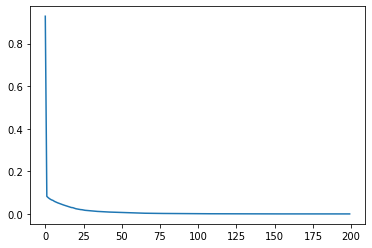

In [233]:
loss_plotter(train_set,100,weights_matrix_list_vec, bias_list_vec, cost_list_vec, sig)

## Result
The elementwise method takes about 136s for 20 Epochs but vectorized needs 13.4 to train the model over 200 epochs.<br> So the vectorized approach decreases the training time dramatically. 

## Train Model on Complete Dataset

In [234]:
%%time
weights_matrix_list_vec, bias_list_vec, cost_list_vec =  train( epoch_num = 5,
                                                                batch_size = 50,
                                                                train_data = train_set,
                                                                learning_rate = 0.01,
                                                                vectorized = 1,
                                                                activation_func = sig,
                                                                activation_derivative = sig_derivative) 

CPU times: user 1min 57s, sys: 1min 7s, total: 3min 4s
Wall time: 46.3 s


### Loss values for each Epoch in the training

accuracy is: 90.5867 


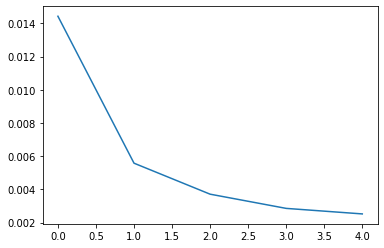

In [235]:
loss_plotter(train_set, len(train_set),weights_matrix_list_vec, bias_list_vec, cost_list_vec, sig )

### Loss values for each Epoch in the Test

accuracy is: 90.4100 


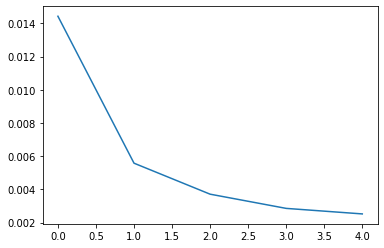

In [236]:
loss_plotter(test_set, len(test_set),weights_matrix_list_vec, bias_list_vec, cost_list_vec, sig )

# Adversarial Attack by Shifting Digit Pattern Matrices

In [199]:
def shift_matirx(matrix, shift):
    matrix = np.roll(matrix,shift)
    matrix[:,:shift] = 0
    return matrix.reshape(-1,1)

In [200]:
shifted_test_set = [(shift_matirx(x[0].reshape(28,28),4),x[1]) for x in test_set]

### Standard Image

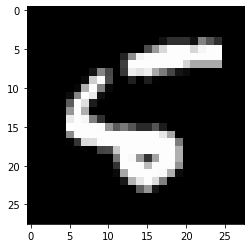

In [201]:
show_image(test_set[8][0])

### Shifted Image

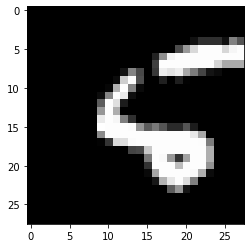

In [202]:
show_image(shifted_test_set[8][0])

### Calculate the Accuracy of trained model by shifted dataset

In [203]:
calculate_accuracy(shifted_test_set, len(shifted_test_set),weights_matrix_list_vec,bias_list_vec, sig )

0.2632

## Result
The model's accuracy falls below 30% because of shifting the data to just 4 pixels, which is a considerable amount of Vulnerability